# Variables and Dependencies
- tfrec_shape = image shape to choose dataset 256, 384, 512, 768
- comp_data = "2020"(only 2020 competition data) or "2019-2020"(2017-2020 data)
- hair_augm = bool (whether hair augment is applied)
- Coarse Dropout Variables:
  * DROP_FREQ Determines proportion of train images to apply coarse dropout to/ (0,1)
  * DROP_CT How many squares to remove from train images when applying dropout
  * DROP_SIZE The size of square side equals IMG_SIZE * DROP_SIZE / (0,1)
- Transform Augmentation Variables:
  * rot, rotation
  * shr, shear zoom
  * hzoom, height zoom
  * wzoom, width shift
  * hshift, height shift
  * wshift, width shift
- crop_size random crop size for each original image size

In [1]:
tfrec_shape = 256
comp_data = "2019-2020"
crop_size = {256: 250, 384: 370, 512: 500, 768: 750}

if comp_data == "2020":
    net_size = {256: 248, 384: 370, 512: 500, 768: 750}
elif comp_data == "2019-2020":
    net_size = {256: 250, 384: 370, 512: 500, 768: 750}

# hair augmentation
if comp_data == "2020":
    hair_augm = {256: False, 384: False, 512: False, 768: False}
elif comp_data == "2019-2020":
    hair_augm = {256: True, 384: True, 512: True, 768: False}
    
# epochs
if comp_data == "2020":
    epochs_num = {256: 13, 384: 15, 512: 15, 768: 15}
elif comp_data == "2019-2020":
    epochs_num = {256: 32, 384: 25, 512: 16, 768: 10}

# model weights
model_weights = 'imagenet' # 'noisy-student'

# device
DEVICE = "TPU" #TPU or GPU

# Edit to change Model Aug/Hyperparams

CFG = dict(
            batch_size = 16,
            read_size = tfrec_shape,
            crop_size = crop_size[tfrec_shape],
            net_size = net_size[tfrec_shape],
    
            # LEARNING RATE
            LR_START = 0.000003,
            LR_MAX = 0.000020,
            LR_MIN = 0.000001,
            LR_RAMPUP_EPOCHS  = 5,
            LR_SUSTAIN_EPOCHS = 0,
            LR_EXP_DECAY = 0.8,
    
            # EPOCHS:
            epochs = epochs_num[tfrec_shape],
    
            # DATA AUGMENTATION
            rot = 180.0,
            shr = 1.5,
            hzoom = 6.0,
            wzoom = 6.0,
            hshift = 6.0,
            wshift = 6.0,
    
            # COARSE DROPOUT
            DROP_FREQ = 0.86, 
            DROP_CT = 16, 
            DROP_SIZE = 0.065,   
    
            # HAIR AUGMENTATION:
            hair_augm = hair_augm[tfrec_shape],
    
            optimizer = 'adam',
            label_smooth_fac = 0.05,
            tta_steps =  25)

In [2]:
! /opt/conda/bin/python3.7 -m pip install -q --upgrade pip
! pip install -q efficientnet
! pip install -q tensorflow-model-optimization

### Import required libraries

In [3]:
import os, random, re, math, time
random.seed(a=42)

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from keras.callbacks import ModelCheckpoint
import tensorflow_model_optimization as tfmot
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import classification_report
import PIL

#import tensorflow_hub as hub

# Read Datasets

In [4]:
BASEPATH = "../input/siim-isic-melanoma-classification"
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

# 2020 TFRecords
GCS_PATH = KaggleDatasets().get_gcs_path(f'melanoma-{tfrec_shape}x{tfrec_shape}')

# 2019 TFRecords
GCS_PATH_2019 = KaggleDatasets().get_gcs_path(f'isic2019-{tfrec_shape}x{tfrec_shape}')

# TRAIN
if comp_data == "2020":
    files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
elif comp_data == "2019-2020":
    ## 2020 + 2019 (all, including 2017+2018):
    files_train = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
    files_train += tf.io.gfile.glob(GCS_PATH_2019 + '/train*.tfrec')
    files_train = np.sort(np.array(files_train)) # np.random.shuffle(files_train)


# TEST
files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

# loading hairs
GCS_PATH_hair_images = KaggleDatasets().get_gcs_path('melanoma-hairs')
hair_images = tf.io.gfile.glob(GCS_PATH_hair_images + '/*.png')
hair_images_tf=tf.convert_to_tensor(hair_images)

# the maximum number of hairs to augment:
n_max= 20

# Scaling factor:
if tfrec_shape != 256:
    scale=tf.cast(CFG['crop_size']/256, dtype=tf.int32)

### TPU configuration

In [5]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


# Functions To implement Augmentation:

* Hair removal
* Coarse Dropout
* Image Transforms
* Crop Augment

In [6]:
#==================== FUNCTION TO PERFORM HAIR REMOVAL ON IMAGE ====================================

def hair_aug_tf(input_img, augment=True):
    
    if augment:
    
        # Copy the input image, so it won't be changed
        img = tf.identity(input_img)

        # Unnormalize: Returning the image from 0-1 to 0-255:
        img = tf.multiply(img, 255)

        # Randomly choose the number of hairs to augment (up to n_max)
        n_hairs = tf.random.uniform(shape=[], maxval=tf.constant(n_max)+1,dtype=tf.int32)

        im_height = tf.shape(img)[0]
        im_width = tf.shape(img)[1]

        if n_hairs == 0:
            # Normalize the image to [0,1]
            img = tf.multiply(img, 1/255)
            return img

        for _ in tf.range(n_hairs):

            # Read a random hair image
            i = tf.random.uniform(shape=[], maxval=tf.shape(hair_images_tf)[0],dtype=tf.int32)
            fname = hair_images_tf[i]
            bits = tf.io.read_file(fname)
            hair = tf.image.decode_jpeg(bits)

            # Rescale the hair image to the right size
            if tfrec_shape != 256:
                # new_height, new_width, _  = scale*tf.shape(hair)
                new_width = scale*tf.shape(hair)[1]
                new_height = scale*tf.shape(hair)[0]
                hair = tf.image.resize(hair, [new_height, new_width])

            # Random flips of the hair image
            hair = tf.image.random_flip_left_right(hair)
            hair = tf.image.random_flip_up_down(hair)

            # Random number of 90 degree rotations
            n_rot = tf.random.uniform(shape=[], maxval=4,dtype=tf.int32)
            hair = tf.image.rot90(hair, k=n_rot)

            # The hair image height and width (ignore the number of color channels)
            h_height = tf.shape(hair)[0]
            h_width = tf.shape(hair)[1]

            # The top left coord's of the region of interest (roi) where the augmentation will be performed
            roi_h0 = tf.random.uniform(shape=[], maxval=im_height - h_height + 1, dtype=tf.int32)
            roi_w0 = tf.random.uniform(shape=[], maxval=im_width - h_width + 1, dtype=tf.int32)

            # The region of interest
            roi = img[roi_h0:(roi_h0 + h_height), roi_w0:(roi_w0 + h_width)]  

            # Convert the hair image to grayscale (slice to remove the trainsparency channel)
            hair2gray = tf.image.rgb_to_grayscale(hair[:, :, :3])

            # Threshold:
            mask = hair2gray>10

            img_bg = tf.multiply(roi, tf.cast(tf.image.grayscale_to_rgb(~mask), dtype=tf.float32))
            hair_fg = tf.multiply(tf.cast(hair[:, :, :3], dtype=tf.int32), tf.cast(tf.image.grayscale_to_rgb(mask), dtype=tf.int32))

            dst = tf.add(img_bg, tf.cast(hair_fg, dtype=tf.float32))

            paddings = tf.stack([[roi_h0, im_height-(roi_h0 + h_height)], [roi_w0, im_width-(roi_w0 + h_width)],[0, 0]])
            # Pad dst with zeros to make it the same shape as image.
            dst_padded=tf.pad(dst, paddings, "CONSTANT")

            # Create a boolean mask with zeros at the pixels of the augmentation segment and ones everywhere else
            mask_img=tf.pad(tf.ones_like(dst), paddings, "CONSTANT")
            mask_img=~tf.cast(mask_img, dtype=tf.bool)

            # Make a hole in the original image at the location of the augmentation segment
            img_hole=tf.multiply(img, tf.cast(mask_img, dtype=tf.float32))

            # Inserting the augmentation segment in place of the hole
            img = tf.add(img_hole, dst_padded)

        # Normalize the image to [0,1]
        img = tf.multiply(img, 1/255)
        
        return img
    else:
        return input_img

In [7]:
#===================== FUNCTION TO PERFORM COARSE AUMENTATION ON IMAGE =============================


def dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [8]:
#============================ ROTATION, SHEAR, ZOOM, TRANSFORMS ====================================

# FUNCTION TO GET ROTATED MATRIX:

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

# FUNCTION TO APPLY AUGMENTATION TRANSFORMS:

def transform(image, cfg):    
    # input image - [dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg["read_size"]
    XDIM = DIM%2
    
    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift)

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [9]:
#========================== FUNCTION TO READ TFRECORD FILEPATHS ====================================

def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

In [10]:
#====================== FUNCTION TO APPLY AUGMENTATION TO EACH IMAGE ===============================

def prepare_image(img, cfg=None, augment=True):
    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0 # # Cast and normalize the image to [0,1]
    
    if augment:
        
        # Data augmentation
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3]) 
        # Coarse dropout
        # img = dropout(img, DIM=cfg['crop_size'], PROBABILITY=cfg['DROP_FREQ'], CT=cfg['DROP_CT'], SZ=cfg['DROP_SIZE'])
        # Other augmentations
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        # Hair augmentation
        img = hair_aug_tf(img, augment=cfg['hair_augm'])
    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])
                                   
    img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])        
    return img

In [11]:
#==================== FUNCTIONS TO OBTAIN IMAGES FROM TFRECORD FILEPATHS ============================

# COUNT NUMBER OF IMAGES IN FILEPATH:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# OBTAIN DATASET:
def get_dataset(files, 
                cfg, augment = False, 
                shuffle = False, repeat = False, 
                labeled=True, return_image_names=True):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg),imgname_or_label), num_parallel_calls=AUTO)
    
    ds = ds.batch(cfg['batch_size'] * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

## Obtaining datasets:

In [12]:
# IMAGES IN DATASET:
num_training_images = int(count_data_items(files_train))
num_test_images = count_data_items(files_test)
print('Dataset: {} training images, {} unlabeled test images'.format(
num_training_images, num_test_images))

Dataset: 57964 training images, 10982 unlabeled test images


In [13]:
ds_train = get_dataset(files_train, CFG, augment=True, shuffle=True, repeat=True)
ds_train = ds_train.map(lambda img, label: (img, tuple([label])))
steps_train = count_data_items(files_train) / (CFG['batch_size'] * REPLICAS)
#ds_test = get_dataset(files_test, CFG, labeled=False)

test_images = ds_train.take(75)
ds_train = ds_train.skip(75)

In [14]:
def plot_accuracy_loss(history):
    plt.plot(history['auc'])
    plt.plot(history['loss'])
    plt.legend(['ROC_AUC', 'loss'], loc = 'upper right')
    plt.title('ROC_AUC vs loss - train vs test')
    plt.xlabel('epoch')
    plt.ylabel('AUC and loss')
    plt.show()

# Building and Compiling Model:

### Model Details:
- Losses used:
    * Binary Focal Loss
    * Binary Cross Entropy
- Optimizer: Adam
- Custom LR Callback
- Model Checkpoint Callback
- Save Model and Infer
- Notes On Deployment

In [15]:
# LEARNING RATE SCHEDULER

def get_lr_callback(cfg):
    lr_start = cfg['LR_START']
    lr_max = cfg['LR_MAX'] * strategy.num_replicas_in_sync
    lr_min = cfg['LR_MIN']
    lr_ramp_ep = cfg['LR_RAMPUP_EPOCHS']
    lr_sus_ep = cfg['LR_SUSTAIN_EPOCHS']
    lr_decay = cfg['LR_EXP_DECAY']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [16]:
# BUILD MODEL
def get_model(cfg, model):
    
    model_input = tf.keras.Input(shape=(cfg['net_size'], cfg['net_size'], 3), name='imgIn')
    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)
    outputs = []

    constructor = getattr(efn, model)
    x = constructor(include_top=False, weights=model_weights, input_shape=(cfg['net_size'], cfg['net_size'], 3), pooling='avg')(dummy)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)
    
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    
    return model

# COMPILE MODEL
def compile_new_model(cfg, model):
    with strategy.scope():
        model = get_model(cfg, model)
     
        losses = tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['label_smooth_fac'])

        
        model.compile(
            optimizer = cfg['optimizer'],
            loss = losses,
            metrics = [tf.keras.metrics.AUC(name='auc')]) 
        
    return model

## Train Effnet B5

In [17]:
model_B5 = compile_new_model(CFG, 'EfficientNetB5')

print("\n Begin Training Models")
history_B5 = model_B5.fit(ds_train, 
                          verbose=1, 
                          steps_per_epoch=steps_train, 
                          epochs = CFG['epochs'], 
                          callbacks=[get_lr_callback(CFG), 
                                    tfmot.sparsity.keras.UpdatePruningStep()]) 

print("\n Done Training model_B5 \n")

115515392/115515256 [==============================] - 4s 0us/step
Model: "aNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imgIn (InputLayer)           [(None, 250, 250, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 250, 250, 3)       0         
_________________________________________________________________
efficientnet-b5 (Model)      (None, 2048)              28513520  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________

 Begin Training Models
Epoch 1/32
453/452 [==============================] - 122s 268ms/step - loss: 0.5133 - auc: 0.6389 - lr: 3.0000e-06
Epoch 2/32
453/452 [===========

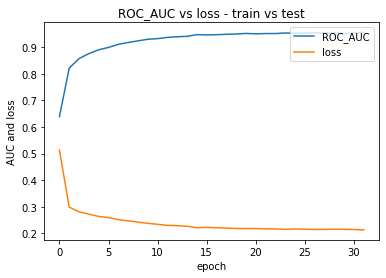

In [18]:
plot_accuracy_loss(history_B5.history)

In [19]:
# Save model:
model_B5.save(f"./EfficientNetB5_{tfrec_shape}x{tfrec_shape}_{comp_data}_epoch{CFG['epochs']}_auc_{round(history_B5.history['auc'][CFG['epochs']-1], 2)}.h5")
# Serialize weights to h5:
model_B5.save_weights(f"./EfficientNetB5_{tfrec_shape}x{tfrec_shape}_{comp_data}_epoch{CFG['epochs']}_auc_{round(history_B5.history['auc'][CFG['epochs']-1], 2)}_weights.h5")

## Train Effnet B6

In [20]:
"""
model_B6 = compile_new_model(CFG, 'EfficientNetB6')

print("\n Begin Training Models")
history_B6 = model_B6.fit(ds_train, 
                          verbose=1, 
                          steps_per_epoch=steps_train, 
                          epochs = CFG['epochs'], 
                          callbacks=[get_lr_callback(CFG), 
                                    tfmot.sparsity.keras.UpdatePruningStep()]) 

print("\n Done Training model_B6 \n")
plot_accuracy_loss(history_B6.history)
# Save model:
model_B6.save(f"./EfficientNetB6_{tfrec_shape}x{tfrec_shape}_{comp_data}_epoch{CFG['epochs']}_auc_{round(history_B6.history['auc'][CFG['epochs']-1], 2)}.h5")
# Serialize weights to h5:
model_B6.save_weights(f"./EfficientNetB6_{tfrec_shape}x{tfrec_shape}_{comp_data}_epoch{CFG['epochs']}_auc_{round(history_B6.history['auc'][CFG['epochs']-1], 2)}_weights.h5")
"""

'\nmodel_B6 = compile_new_model(CFG, \'EfficientNetB6\')\n\nprint("\n Begin Training Models")\nhistory_B6 = model_B6.fit(ds_train, \n                          verbose=1, \n                          steps_per_epoch=steps_train, \n                          epochs = CFG[\'epochs\'], \n                          callbacks=[get_lr_callback(CFG), \n                                    tfmot.sparsity.keras.UpdatePruningStep()]) \n\nprint("\n Done Training model_B6 \n")\nplot_accuracy_loss(history_B6.history)\n# Save model:\nmodel_B6.save(f"./EfficientNetB6_{tfrec_shape}x{tfrec_shape}_{comp_data}_epoch{CFG[\'epochs\']}_auc_{round(history_B6.history[\'auc\'][CFG[\'epochs\']-1], 2)}.h5")\n# Serialize weights to h5:\nmodel_B6.save_weights(f"./EfficientNetB6_{tfrec_shape}x{tfrec_shape}_{comp_data}_epoch{CFG[\'epochs\']}_auc_{round(history_B6.history[\'auc\'][CFG[\'epochs\']-1], 2)}_weights.h5")\n'

## Deployable Format

* To implement The model we need to export the model into .tflite format using Tensorflow's   python TFLite API. We can convert Saved Models as well as Keras Models From TFlite, if compatible. TFLite can then be integrated in Android Apps using MLKit and Flutter.
* If there maybe a problem in deployment a viable course of action is to train the TFLite compatible Effnet Models in TFHub, and fine tune and then save them.
* The TFlite models is big so we will implement Pruning and Quantisation

EFFNET B5

In [21]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_B5)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model_B5 = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_pruned_model_B5 = converter.convert()

In [22]:
open("pruned_model_B5.tflite", "wb").write(pruned_tflite_model_B5)

113249064

In [23]:
open("quantized_pruned_model_B5.tflite", "wb").write(quantized_pruned_model_B5)

28902672

EFFNET B6

In [24]:
"""
model_for_export = tfmot.sparsity.keras.strip_pruning(model_B6)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model_B6 = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_pruned_model_B6 = converter.convert()
open("pruned_model_B6.tflite", "wb").write(pruned_tflite_model_B6)
open("quantized_pruned_model_B6.tflite", "wb").write(quantized_pruned_model_B6)
"""

'\nmodel_for_export = tfmot.sparsity.keras.strip_pruning(model_B6)\nconverter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)\npruned_tflite_model_B6 = converter.convert()\n\nconverter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)\nconverter.optimizations = [tf.lite.Optimize.DEFAULT]\nquantized_pruned_model_B6 = converter.convert()\nopen("pruned_model_B6.tflite", "wb").write(pruned_tflite_model_B6)\nopen("quantized_pruned_model_B6.tflite", "wb").write(quantized_pruned_model_B6)\n'

## Evaluating pruned and quantised model:

In [25]:
test_labels = []
for i, j in enumerate(test_images):
    test_labels.extend(j[1][0].numpy()) 

In [26]:
def evaluate_model(interpreter, test_images):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on ever y image in the "test" dataset.
    prediction_digits = []
    for i, test_image in enumerate(test_images):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
            #Pre-processing: add batch dimension and convert to float32 to match with
            #the model's input data format.
            #test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
            #interpreter.set_tensor(input_index, test_image)

            # Run inference.
            interpreter.invoke()

            # Post-processing: remove batch dimension and find the digit with highest
            # probability.
            output = interpreter.tensor(output_index)
            digit = np.argmax(output()[0])
            prediction_digits.append(digit)
            print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy, prediction_digits

In [27]:
print("EFFNET B5 - With Augmentation Accuracy")
interpreter = tf.lite.Interpreter(model_content = quantized_pruned_model_B5)
interpreter.allocate_tensors()

test_accuracy, preds = evaluate_model(interpreter, test_images)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)

EFFNET B5 - With Augmentation Accuracy
Evaluated on 0 results so far.


Pruned and quantized TFLite test_accuracy: 0.9270833333333334


In [28]:
"""
print("EFFNET B6 - With Augmentation Accuracy")
interpreter = tf.lite.Interpreter(model_content = quantized_pruned_model_B6)
interpreter.allocate_tensors()

test_accuracy,preds = evaluate_model(interpreter, test_images)

print('Pruned and quantized TFLite test_accuracy:', test_accuracy)
"""

'\nprint("EFFNET B6 - With Augmentation Accuracy")\ninterpreter = tf.lite.Interpreter(model_content = quantized_pruned_model_B6)\ninterpreter.allocate_tensors()\n\ntest_accuracy,preds = evaluate_model(interpreter, test_images)\n\nprint(\'Pruned and quantized TFLite test_accuracy:\', test_accuracy)\n'

### Prediction image shape: (1,256,256,3)
* 1 is the batch dimension and (256,256,3) is the image shape

